### Part I

In [1]:
# current tensorflow version for reproducibility
# minimum version required in 1.14
import tensorflow as tf
tf.__version__
random_state = 49

In [2]:
# if you are using google colab, the data set can be uploaded to google drive and mounted to colab
#from google.colab import drive
#drive.mount('/content/drive')

### Data Preparation

In [3]:
# map categories to integers
train_folders = ['traffic_signs_train/belgium/', 
                 'traffic_signs_train/germany/']
categories_to_number_map = {
                            "speed limit 20"         : 0,
                            "speed limit 50"         : 1,
                            "speed limit 70"         : 2,
                            "no overtaking"          : 3,
                            "roundabout"             : 4,
                            "priority road"          : 5,
                            "give way"               : 6,
                            "stop"                   : 7,
                            "road closed"            : 8,
                            "no heavy goods vehicles": 9,
                            "no entry"               : 10,
                            "obstacles"              : 11,
                            "left hand curve"        : 12,
                            "right hand curve"       : 13,
                            "keep straight ahead"    : 14,
                            "slippery road"          : 15,
                            "keep straight or turn right" : 16,
                            "construction ahead"     : 17,
                            "rough road"             : 18,
                            "traffic lights"         : 19,
                            "schoolahead"            : 20
                           }
    

In [4]:

import glob
import numpy as np
import random
class DataLoader:
    """"
    DataLoader
    @description
    Reads data from disk and divides it in to train and test set. Also checks for imbalanced data.

    @params
    train_folders: list of folders where the train data is available
    categories: dictionary to map each class with a number. Numbers should be 
    sequential, starting from 1
    test_size: the percent of data to be divided to test set. 
    check_imbalance: if set to True, will return same number of data per class
    seed: random seed

    @methods
    get_data: returns test and train data when test_size is greater than 0
    else only train data.
    """
    def __init__(self, train_folders, categories, test_size=0.2, check_imbalance=True, seed=666):
        self.train_folders = train_folders
        self.categories = categories
        self.test_ratio = test_size
        self.check_imbalance = check_imbalance
        self.seed = seed
        print("DataLoader initialized")
        
    def __get_no_of_files_per_category__(self):
        if not self.check_imbalance:
            return -1
        else:
            size_p_category = []     
            for category in self.categories.values():
                count_files = 0
                for folder in self.train_folders:
                    # print(folder + str(category) + '/*.ppm')
                    files = glob.glob(folder + str(category) + '/*.ppm')
                    assert(len(files) > 0)
                    count_files += len(files)
                size_p_category.append(count_files)
            #print(size_p_category)
            return min(size_p_category)
        
    # split the data in train and test set
    def get_data(self):   
        n_files = self.__get_no_of_files_per_category__()
        train_dict, test_dict = {}, {}
        for category in self.categories.values():
            files = []
            for folder in self.train_folders:
                #print('processing category {} for {}'.format(category, folder))
                curr_dir_files = glob.glob(folder + str(category) + '/*.ppm')
                files.extend(curr_dir_files.copy())
            random.seed(self.seed)
            random.shuffle(files)
            if n_files > 0:
                files = files[:n_files]
                train_size = int(n_files * (1 - self.test_ratio))
                # print("train size", train_size)
                # test_size = int(n_files * self.test_ratio)
            elif n_files == 0:
                raise Exception("No training data for ", category)
            else:
              # no check for balanced dataset here
              train_size = int(len(files) * (1 - self.test_ratio))
            assert(train_size<=len(files))
            train_dict[category] = files[:train_size].copy()
            if self.test_ratio > 0:   
                test_dict[category] = files[train_size+1:].copy()
        print("data loading done")
        if self.test_ratio > 0:   
                return train_dict, test_dict
        return train_dict
            

DataLoader initialized
data loading done


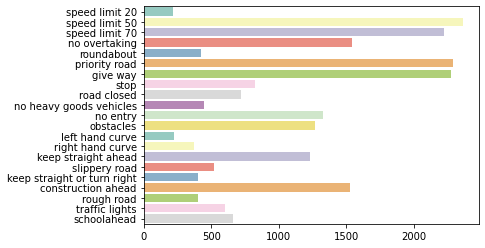

In [5]:
# show the number of data instances per class
data_loader = DataLoader(train_folders,categories_to_number_map, check_imbalance=False, test_size=0, seed=random_state) # check imbalance is set to False
data_all = data_loader.get_data()

# return  top key for a value
def get_key(dic, val): 
    for key, value in dic.items(): 
         if val == value: 
             return key 
    raise Exception("Key doesn't exist")

# data plot functiton
import seaborn as sns
def plot_bar(data_dict, categories_to_number_map):
  x = []
  y = []
  for key, val in data_dict.items():
    x.append(get_key(categories_to_number_map, key))
    y.append(len(val))
  #plt.bar(x,y)
  sns.barplot(y,x, palette='Set3')

plot_bar(data_all, categories_to_number_map)

#### The dataset has different image sizes and is heavily skewed (seen from the above plot). Possible strategies to deal with:<br/>
        1) Sample equal number of data from each class. Two cases:
            a) Over sampling: Sample more data from classes with less number of sample using image augmentations
            b) Under sampling: Use the count of the class that has least number of samples and use that count for sampling from other classes 

        2) Add weights to samples during training, i.e., use higher weights for classes with less data.

#### Using strategy 1(b) + oversample on undersampled data and using 20% as validation data.  Check datacounts after undersampling.

DataLoader initialized
data loading done
Train set


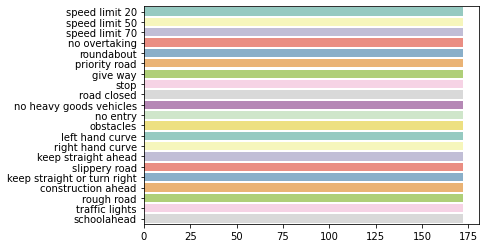

In [6]:
# using strategy 1(b) and using 20% as validation data
# check imbalance is set to True to get balanced dataset using undersampling
data_loader = DataLoader(train_folders,categories_to_number_map, check_imbalance=True, test_size=0.2, seed=random_state) 
train_data, val_data = data_loader.get_data()

# show data counts per class in train and test set
print("Train set")
plot_bar(train_data, categories_to_number_map)

Validation set


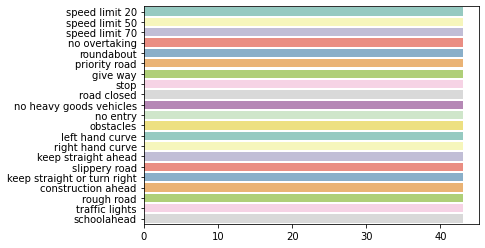

In [7]:
print("Validation set")
plot_bar(val_data, categories_to_number_map)

#### DataGenerator to generate data in the runtime for training.
    1) configurable with mini-batch size, shape of the image
    2) Allow augmentations parameters

In [8]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
class DataGenerator(Sequence):
    """
    Responsible for providing normalised data to the model in runtime, in one hot encoded fashion.

    @params
    batch_size    :   mini-batch number of images to be provided during one pass
    shape         :   the size to which image should be resized. Must be 3 channel.
    categories_to_number_map  :   mapping of folder to folders to unique number. Must be sequential.
    aug           :   the nature of augmentations to be done on images. As per keras ImageDataGenerator
    aug_p_img     :   number of augmented images per image read from the disk.
    seed          : random seed.
    selected_labels :  which labels to select from the labels provided in categories_to_number_map. Default
    is to use all.
    """

    def __init__(self, batch_size, shape, X_dict, categories_to_number_map, aug={}, aug_p_img=1, seed=666, selected_labels=None):
        self.batch_size = batch_size
        self.shape = shape
        self.x_dict = X_dict
        self.categories_to_number_map = categories_to_number_map
        self.seed = seed
        self.augmenter_x = ImageDataGenerator(**aug)
        self.aug_p_img = aug_p_img
        self.selected_labels = selected_labels
        # create placeholders for the images and labels
        self.__images_batch__ = np.empty((batch_size*aug_p_img, shape[0], shape[1], shape[2]), dtype=np.float32)
        self.__labels_batch__ = np.empty((batch_size*aug_p_img, len(categories_to_number_map)), dtype=np.uint8)
        
        self.x_data, self.y_data = self.__load_data__()
        # print(len(self.x_data))
        self.indexes = np.arange(len(self.x_data))
    
    # assigns numeric label to all data points.
    def __load_data__(self):
        x, y = [],[]
        for key, value in self.categories_to_number_map.items():
            #print(key)
            #print(value)
            if self.selected_labels != None and key not in self.selected_labels:
              continue
            x.extend(self.x_dict[value])
            labels = list(np.ones(len(self.x_dict[value])) * self.categories_to_number_map[key])
            y.extend(labels) 
        
        random.seed(self.seed)
        random.shuffle(x)
        random.seed(self.seed)
        random.shuffle(y)
        return np.array(x),np.array(y)
    
    def __get_one_hot_encoding__(self, indexes):
        y_labels = self.y_data[indexes]
        size = len(self.categories_to_number_map)
        for i, label in enumerate(y_labels):
            one_hot_encoded = np.zeros(size).astype(np.float32)
            one_hot_encoded[int(label)] = 1.0
            for j in range(self.aug_p_img):
                self.__labels_batch__[i*self.aug_p_img + j] = one_hot_encoded.copy()
            
        
    def __populate_batches__(self, indexes):
        x_files = self.x_data[indexes]
        
        for i, file in enumerate(x_files):
            #print(file)
            img = cv2.imread(file)
            img = cv2.resize(img, (self.shape[0], self.shape[1]))
            img = np.expand_dims(img, axis=0)
            image_iterator = self.augmenter_x.flow(img, batch_size=self.aug_p_img, seed=self.seed)
            for j in range(self.aug_p_img):
                image_x = image_iterator.next()[0].copy()
                self.__images_batch__[i*self.aug_p_img + j] = image_x / 255.
        
        
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        self.__populate_batches__(indexes)
        self.__get_one_hot_encoding__(indexes)
        return self.__images_batch__, self.__labels_batch__, [None]
    
    def __len__(self):
        return len(self.indexes)
    

#### Add Augmentations

    1) Gaussian blur to 10% of the images
    2) Rotation of objects by 15 degrees
    3) Zooming in / out
    4) Minor Height/Width shift - considering posibility of not so accurate bounding box detector


In [66]:
# add Gaussian blur to the images
import random
def add_preprocessing(img):
    # aadding gaussian blur for 30% of the images
    def add_gaussian_blur(img):
        if( random.random() < 0.1):
            return cv2.GaussianBlur(img,(5,5),0)
        return img
    
    img = add_gaussian_blur(img)
    return img

aug_x = dict(rotation_range=10,
            brightness_range=(0.8,1.2),
            zoom_range=0.1,
            width_shift_range=0.05,
            height_shift_range=0.05,
            shear_range=0.05,
            preprocessing_function=add_preprocessing,
            fill_mode="nearest")



#### Setting some parmeters
    1) mini batch size to 16
    2) number of augmentation per image = 3 for train images
    3) resizing images to 32 x 32 x 3
    4) No augmentation for validation images
    

In [67]:
batch_size = 32
aug_p_img = 5
shape = (32, 32, 3)
train_data_gen = DataGenerator(batch_size, shape, train_data, categories_to_number_map, aug_x, aug_p_img=aug_p_img, seed=random_state)
# donot apply augmentation for validation data
val_data_gen = DataGenerator(batch_size, shape, val_data, categories_to_number_map, seed=random_state)

#### Let's see some data from the DataGenerator for train and validation data


Augmented train images


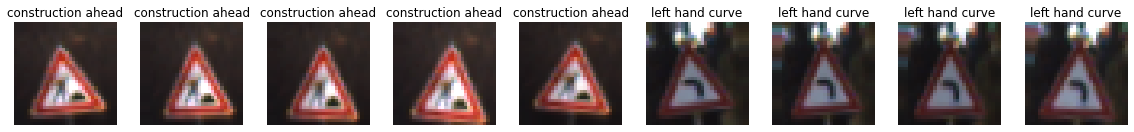

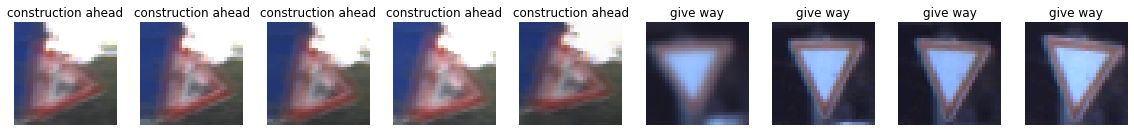

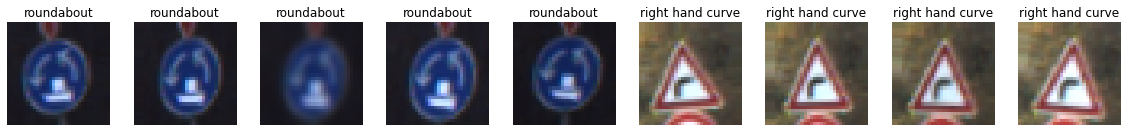

In [68]:
import matplotlib.pyplot as plt
def plot(data, size, categories_to_number_map, apply_fn=None):
    imgs, y_one_hot, _ = data
    iter = size
    fig = plt.figure(figsize=(20, 20))
    for i in range(1,iter+1):
        ax = fig.add_subplot(size, size, i)
        img = cv2.cvtColor(imgs[i-1], cv2.COLOR_BGR2RGB)
        if apply_fn is not None:
            img = apply_fn(img)
        ax.imshow(img)
        label = get_key(categories_to_number_map, np.argmax(y_one_hot[i-1]))
        ax.set_title(label)
        plt.axis('off')
        
print("Augmented train images")       
plot(train_data_gen[0], 9, categories_to_number_map)
plot(train_data_gen[3], 9, categories_to_number_map)
plot(train_data_gen[15], 9, categories_to_number_map)

Validation images


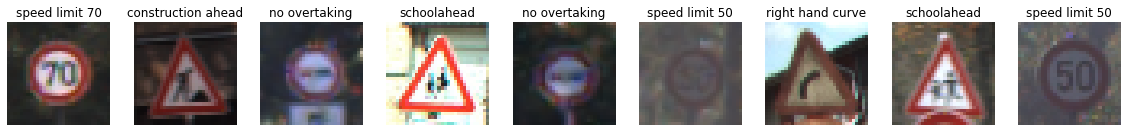

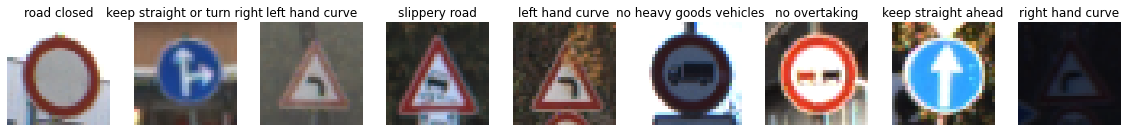

In [69]:
print("Validation images")       
plot(val_data_gen[0], 9, categories_to_number_map)
plot(val_data_gen[1], 9, categories_to_number_map)

#### Provide a Resnet model related dependencies

In [75]:
from tensorflow.keras.layers import Input, Conv2D, Activation, BatchNormalization, MaxPooling2D, Dense, Dropout, Add, Flatten
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Model
class ModelProvider:
    """
    Model Provider creates the model based on the configurations provided

    @params
    shape       :   initial shape of image as input
    loss        :   loss function as per Keras
    optimiser   :   which optimiser to use
    check_point :   the location where the model will be saved
    n_classes   :   number of classes to differentiate

    """
    def __init__(self, shape, loss, optimiser, check_point, n_classes ):
        self.loss = loss
        self.optimiser = optimiser
        self.n_classes = n_classes
        self.check_point = check_point
        self.shape = shape

    """
    Creates callbacks 
    """
    def create_callbacks(self):
        from tensorflow.keras.callbacks import ModelCheckpoint, Callback
        checkpoint_file = str(self.check_point) 
        checkpoint = ModelCheckpoint(checkpoint_file, monitor='val_loss',
                                    save_best_only=True)
        print('callbacks created.')

        return [checkpoint]
    
    """
    One identity block of ResNet without BN
    """
    def __identity_block__(self, x, n_filters, strides=1, kernel_size=(3,3), upscale=False):
        x_prev = x
        
        x = Conv2D(filters=n_filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer='glorot_uniform') (x)
        #x = BatchNormalization()(x)
        x = Activation(relu)(x)
        x = Conv2D(filters=n_filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer='glorot_uniform') (x)
        #x = BatchNormalization()(x)
        x = Activation(relu)(x)  
        if upscale:
            x_prev = Conv2D(kernel_size=1, filters=n_filters, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
        x = Add()([x, x_prev])
        x = Activation(relu)(x)
        
        return x
    
    """
    Gives model created by the ModelProvider
    """
    def create_model(self):
                           
        input_tensor = Input(self.shape)
        x = Conv2D(kernel_size=3, filters=16, strides=1, padding='same', kernel_initializer='glorot_uniform',)(input_tensor)
        x = self.__identity_block__(x, 16)
        x = MaxPooling2D((2,2))(x)
        x = self.__identity_block__(x, 16)
        x = MaxPooling2D((2,2))(x)
        x = self.__identity_block__(x, 16)
        x = MaxPooling2D((2,2))(x)
        x = self.__identity_block__(x, 16)
        x = Flatten()(x)
        x = Dense(256)(x)
        #x = BatchNormalization()(x)
        x = Activation(relu)(x)
        # x = Dropout(0.5)(x)
        x = Dense(self.n_classes)(x)
        x = Activation(softmax)(x)
    
        model = Model(inputs=input_tensor, outputs=x)
        model.compile(loss=self.loss, optimizer=self.optimiser, metrics=['accuracy'])
        print('model created')
        return model
     

#### Train the model

    1) checkpoint file
    2) categorical cross entropy as loss function
    3) Adam with 0.0001 learning rate as optimiser
    4) setting for 10 epochs initially


In [76]:
checkpoint = 'class.h5'
optimiser = tf.keras.optimizers.Adam(lr=0.001)
model_provider = ModelProvider(shape, 'categorical_crossentropy', optimiser, checkpoint, len(categories_to_number_map))
model = model_provider.create_model()
callback_list = model_provider.create_callbacks()
epochs = 10

model created
callbacks created.


In [77]:
history = model.fit_generator(generator=train_data_gen,
                    validation_data=val_data_gen,
                    epochs=epochs,
                    callbacks=callback_list)

Train for 3612 steps, validate for 903 steps
Epoch 1/10
3612/3612 [==============================] - 76s 21ms/step - loss: 0.3467 - accuracy: 0.9116 - val_loss: 0.5582 - val_accuracy: 0.7842
Epoch 2/10
3612/3612 [==============================] - 73s 20ms/step - loss: 0.0328 - accuracy: 0.9925 - val_loss: 0.3349 - val_accuracy: 0.9060
Epoch 3/10
3612/3612 [==============================] - 72s 20ms/step - loss: 0.0186 - accuracy: 0.9961 - val_loss: 0.0579 - val_accuracy: 0.9679
Epoch 4/10
3612/3612 [==============================] - 71s 20ms/step - loss: 0.0106 - accuracy: 0.9978 - val_loss: 0.2266 - val_accuracy: 0.9078
Epoch 5/10
3612/3612 [==============================] - 71s 20ms/step - loss: 0.0093 - accuracy: 0.9982 - val_loss: 0.0847 - val_accuracy: 0.9677
Epoch 6/10
3612/3612 [==============================] - 71s 20ms/step - loss: 0.0098 - accuracy: 0.9983 - val_loss: 0.0395 - val_accuracy: 0.9993
Epoch 7/10
3612/3612 [==============================] - 71s 20ms/step - loss: 0

#### Show Training vs Validation accuracy and loss

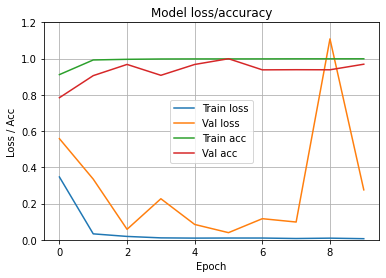

In [78]:
# Plot training vs validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0, 1.2])
plt.title('Model loss/accuracy')
plt.ylabel('Loss / Acc')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss', 'Train acc', 'Val acc'])
plt.grid()

In [79]:
checkpoint = 'class.h5'
optimiser = tf.keras.optimizers.Adam(lr=0.001)
model_provider = ModelProvider(shape, 'categorical_crossentropy', optimiser, checkpoint, len(categories_to_number_map))
model = model_provider.create_model()
model.load_weights(checkpoint)

model created


#### Experiment : See class wise accuracy on **validation** data

completed


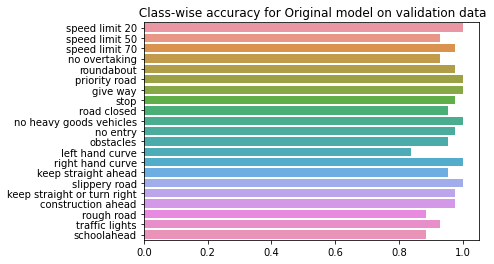

In [101]:
# class wise accuracy
keys = []
vals = []
for key in categories_to_number_map.keys():
    temp_val_data_gen = DataGenerator(1, shape, val_data, categories_to_number_map, seed=random_state, selected_labels=[key])
    _, acc = model.evaluate_generator(temp_val_data_gen)
    keys.append(key)
    vals.append(acc)
sns.barplot(vals, keys).set(title=' Class-wise accuracy for Original model on validation data\n')
print('completed')

#### See how the model performs on **test data**
    1) Print the average loss and accuracy
    2) Show class wise accuracy on test data

In [81]:
metrics = ['accuracy']
test_folders = ['traffic_signs_test/belgium/']
test_data_loader = DataLoader(test_folders,categories_to_number_map, check_imbalance=False, test_size=0, seed=random_state)
test_data = test_data_loader.get_data()
test_data_gen = DataGenerator(batch_size, shape, test_data, categories_to_number_map, seed=random_state)
scores = model.evaluate_generator(test_data_gen)
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("Average {}: {:.5}".format(metric, value))

DataLoader initialized
data loading done
Loss: 3.7811
Average accuracy: 0.90582


#### Model on the test data acheived 91% accuracy

DataLoader initialized
data loading done
completed


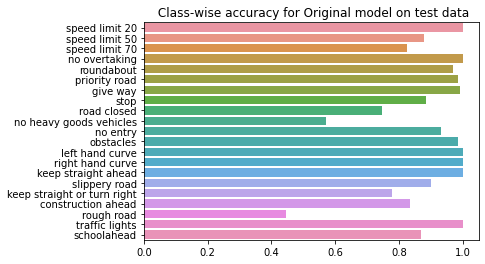

In [100]:
# class wise accuracy
test_folders = ['traffic_signs_test/belgium/']
data_loader_test = DataLoader(test_folders,categories_to_number_map, test_size=0, seed=random_state, check_imbalance=False)
test_data = data_loader_test.get_data()
keys = []
vals = []
test_acc_dict = {} # for comparison with prunned model later
for key in categories_to_number_map.keys():
    temp_test_data_gen = DataGenerator(1, shape, test_data, categories_to_number_map, seed=random_state, selected_labels=[key])
    _, acc = model.evaluate_generator(temp_test_data_gen)
    keys.append(key)
    vals.append(acc)
    test_acc_dict[key] = acc
sns.barplot(vals, keys).set(title=' Class-wise accuracy for Original model on test data\n')
print('completed')

#### Visualise some predictions on test data. 
    1) Correct predictions marked in green, incorrect in red

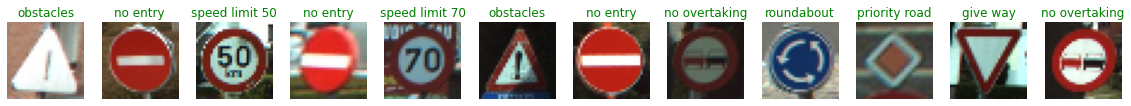

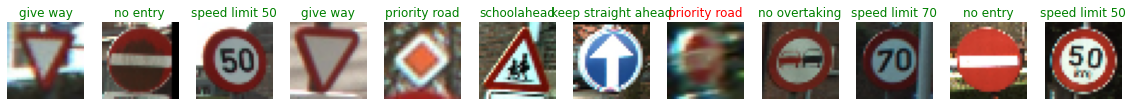

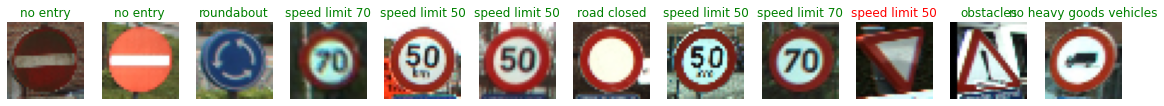

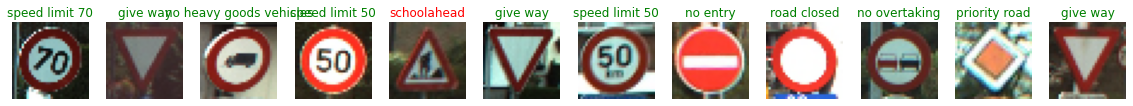

In [83]:

def plot_prediction(data, size, categories_to_number_map, model):
    imgs, y_one_hot_gt, _ = data
    y_one_hot_pred = model.predict(imgs)
    iter = size
    fig = plt.figure(figsize=(20, 20))
    for i in range(1,iter+1):
        ax = fig.add_subplot(size, size, i)
        img = cv2.cvtColor(imgs[i-1], cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        y_gt = np.argmax(y_one_hot_gt[i-1])
        y_pred = np.argmax(y_one_hot_pred[i-1])
        label = get_key(categories_to_number_map, y_pred)
        ax.set_title(label, color='g' if y_gt == y_pred else 'r' )
        plt.axis('off')

plot_prediction(test_data_gen[2], 12, categories_to_number_map, model)
plot_prediction(test_data_gen[1], 12, categories_to_number_map, model)
plot_prediction(test_data_gen[12], 12, categories_to_number_map, model)
plot_prediction(test_data_gen[4], 12, categories_to_number_map, model)

#### Prunning model to make it suitable for edge devices like mobiles
    1) Prun the model step by step
    2) Retrain with train data and validate with the validation data

In [85]:
import tensorflow_model_optimization as tfmot
from tensorflow.keras.models import load_model

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
epochs = 2
x = list(train_data.values())
result = sum(x, [])
num_images = len(result)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
import tempfile
logdir = tempfile.mkdtemp()
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
checkpoint_file = 'model_prunned.h5'
checkpoint = ModelCheckpoint(checkpoint_file, monitor='val_loss',
                                    save_best_only=True)
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  checkpoint  
]

epochs=2  
model_for_pruning.fit_generator(generator=train_data_gen,
                    validation_data=val_data_gen,
                    epochs=epochs,
                    callbacks=callbacks)

Train for 3612 steps, validate for 903 steps
Epoch 1/2
3612/3612 [==============================] - 152s 42ms/step - loss: 0.0292 - accuracy: 0.9930 - val_loss: 0.0552 - val_accuracy: 0.9688
Epoch 2/2
3612/3612 [==============================] - 148s 41ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.1028 - val_accuracy: 0.9386


#### Load the best prunned model

In [86]:
checkpoint = 'model_prunned.h5'
model_for_pruning.load_weights(checkpoint)

#### See how the prunned model performs on test data

In [87]:
metrics = ['accuracy']
test_folders = ['traffic_signs_test/belgium/']
test_data_loader = DataLoader(test_folders,categories_to_number_map, check_imbalance=False, test_size=0, seed=random_state)
test_data = test_data_loader.get_data()
test_data_gen = DataGenerator(batch_size, shape, test_data, categories_to_number_map, seed=random_state)
scores = model_for_pruning.evaluate_generator(test_data_gen)
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("Average {}: {:.5}".format(metric, value))

DataLoader initialized
data loading done
Loss: 2.3559
Average accuracy: 0.87489


#### Original Model accuracy: 91%, Prunned model accuracy: 87%
#### Class-wise accuracy of the prunned model

DataLoader initialized
data loading done
completed


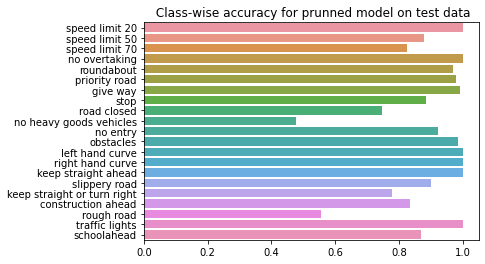

In [102]:
# class wise accuracy for prunned model
data_loader_test = DataLoader(test_folders,categories_to_number_map, test_size=0, seed=random_state, check_imbalance=False)
test_data = data_loader_test.get_data()
keys = []
vals = []
prun_test_acc = {}
for key in categories_to_number_map.keys():
    temp_test_data_gen = DataGenerator(1, shape, test_data, categories_to_number_map, seed=random_state, selected_labels=[key])
    _, acc = model_for_pruning.evaluate_generator(temp_test_data_gen)
    keys.append(key)
    vals.append(acc)
    prun_test_acc[key] = acc
sns.barplot(vals, keys).set(title=' Class-wise accuracy for prunned model on test data\n')
print('completed')

#### Part 2 
    1) Introducing Focal loss to add more weightage to not so well classified examples

In [90]:
def binary_focal_loss(gamma=2., alpha=.25):
        from tensorflow.keras import backend as K
        """
        Binary form of focal loss.
          FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
          where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
        References:
            https://arxiv.org/pdf/1708.02002.pdf
        Usage:
         model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
        """
        def binary_focal_loss_fixed(y_true, y_pred):
            """
            :param y_true: A tensor of the same shape as `y_pred`
            :param y_pred:  A tensor resulting from a sigmoid
            :return: Output tensor.
            """
            pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
            pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

            epsilon = K.epsilon()
            # clip to prevent NaN's and Inf's
            pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
            pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

            return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
                   -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

        return binary_focal_loss_fixed

In [91]:
import tensorflow_model_optimization as tfmot
from tensorflow.keras.models import load_model

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
epochs = 2
x = list(train_data.values())
result = sum(x, [])
num_images = len(result)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning_fl = prune_low_magnitude(model, **pruning_params)
loss = binary_focal_loss()
# `prune_low_magnitude` requires a recompile.
model_for_pruning_fl.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy'])
import tempfile
logdir = tempfile.mkdtemp()
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
checkpoint_file = 'model_prunned_fl.h5'
checkpoint = ModelCheckpoint(checkpoint_file, monitor='val_loss',
                                    save_best_only=True)
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  checkpoint  
]
 
model_for_pruning_fl.fit_generator(generator=train_data_gen,
                    validation_data=val_data_gen,
                    epochs=epochs,
                    callbacks=callbacks)

Train for 3612 steps, validate for 903 steps
Epoch 1/2
3612/3612 [==============================] - 157s 43ms/step - loss: 1.0255e-04 - accuracy: 0.9985 - val_loss: 0.0023 - val_accuracy: 0.9381
Epoch 2/2
3612/3612 [==============================] - 153s 42ms/step - loss: 1.2427e-04 - accuracy: 0.9984 - val_loss: 0.0020 - val_accuracy: 0.9378


In [92]:
metrics = ['accuracy']
test_folders = ['traffic_signs_test/belgium/']
test_data_loader = DataLoader(test_folders,categories_to_number_map, check_imbalance=False, test_size=0, seed=random_state)
test_data = test_data_loader.get_data()
test_data_gen = DataGenerator(batch_size, shape, test_data, categories_to_number_map, seed=random_state)
scores = model_for_pruning_fl.evaluate_generator(test_data_gen)
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("Average {}: {:.5}".format(metric, value))

DataLoader initialized
data loading done
Loss: 0.0096229
Average accuracy: 0.93651


#### Original Model accuracy: 91%, Prunned model accuracy: 87%, Prunned model with Focal loss: 94%
#### Class-wise accuracy of the prunned model with Focal loss

DataLoader initialized
data loading done
completed


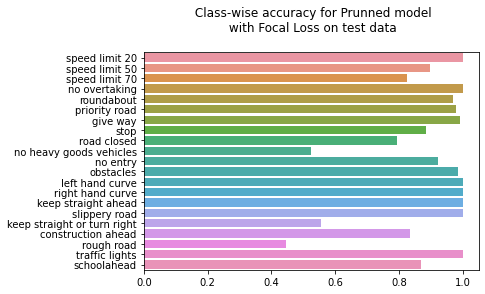

In [105]:
# class wise accuracy for prunned model with focal loss
data_loader_test = DataLoader(test_folders,categories_to_number_map, test_size=0, seed=random_state, check_imbalance=False)
test_data = data_loader_test.get_data()
keys = []
vals = []
prun_test_acc_fl = {}
for key in categories_to_number_map.keys():
    temp_test_data_gen = DataGenerator(1, shape, test_data, categories_to_number_map, seed=random_state, selected_labels=[key])
    _, acc = model_for_pruning_fl.evaluate_generator(temp_test_data_gen)
    keys.append(key)
    vals.append(acc)
    prun_test_acc_fl[key] = acc
sns.barplot(vals, keys).set(title=' Class-wise accuracy for Prunned model\n with Focal Loss on test data\n')
print('completed')

#### Classwise comparison for all the 3 models - original vs prunned vs prunned with focal loss

(0.0, 1.1)

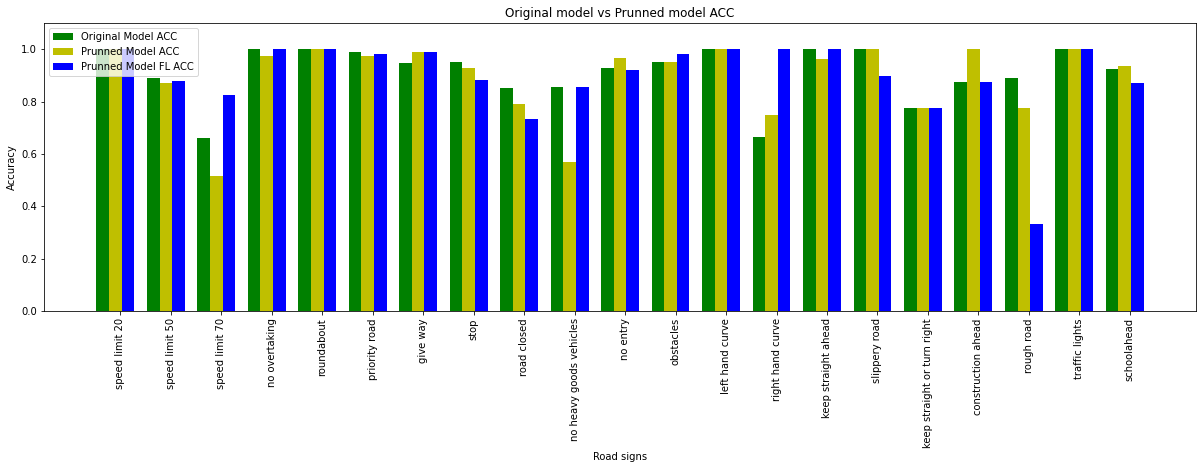

In [94]:
# get the data and map it correctly
org_acc_list = []
prun_acc_list = []
label_list = []
prun_acc_fl_list = []
for key in test_acc_dict.keys():
    label_list.append(key)
    org_acc_list.append(test_acc_dict[key])
    prun_acc_list.append(prun_test_acc[key])
    prun_acc_fl_list.append(prun_test_acc_fl[key])
# data arrange sequentially, now plot
X = np.arange(21)
bar_width = 0.35
fig = plt.figure(figsize=(16,4))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, org_acc_list, color = 'g', width = 0.25, label='Original Model ACC')
ax.bar(X + 0.25, prun_acc_list, color = 'y', width = 0.25, label='Prunned Model ACC')
ax.bar(X + 0.5, prun_acc_fl_list, color = 'b', width = 0.25, label='Prunned Model FL ACC')
plt.xlabel('Road signs')
plt.ylabel('Accuracy')
plt.title('Original model vs Prunned model ACC')
plt.xticks(X + bar_width, label_list, rotation='vertical')
plt.legend()
plt.ylim([0, 1.1])
#####plt.plot()

### Discussion
#### Data analysis and preparation
    1) The provided dataset is heavily skewed. Therefore one of the startegies to deal with imbalanced dataset is undersampling. This has been used, however augmentations of the images were done on the undesampled data.
    2) DataGenerator with help of DataProvider provides augmented images. Various augmentations e.g., brightness, rotations by small degrees (<=15 degrees), zooming, width and height shift and gaussian noise were added to make more generalised data
#### Model selection
    1) Resnet insprired model has been developed here. However any existing state-of-the-art models like ResNeXt, EfficientNet can be used.
    2) To reduce the number of parameteres, the model was prunned.
#### Experiment
    1) Class wise accuracy analysis of the original model, prunned model and prunned model with focal loss has been shown here  
#### Results
    1) The average acc for the models are below:
        Original model: 91%
        Prunned model: 87%
        Prunned model with Focal loss: 94%
    2) The original prunned model was less accurate to the original model which was as expected. The prunned model with Focal Loss performed the best.
    3) Right turn accuracy has been significantly increased with Focal Loss, however rough road has gone down
#### Potential future improvements:
    1) More training data can improve the classification accuracy
    2) Using of transfer learning with already existing models like ResNeXt, EfficientNet
    3) Using more sophisticated loss, e.g., adding higher weightage for bad performing classes 
    
